In [1]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def iqr_filter(x_list):
    x = np.array(x_list)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [val for val in x if lower <= val <= upper]

def get_lane_midline_inner_edges_outlier_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === Sobel X edges ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === HSV yellow mask ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === Extract left (yellow ∩ sobel) and right (sobel only) points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === Overlay image ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if len(x_lefts) >= 3:
            x_lefts = iqr_filter(x_lefts)
        if len(x_rights) >= 3:
            x_rights = iqr_filter(x_rights)

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw edges
        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    # === Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === Save debug outputs ===
    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === Deviation computation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, mid_pts, deviation

def compute_slope_error(image, mid_pts, num_points=5):
    if len(mid_pts) < num_points * 2:
        return None  # Not enough points

    top_pts = mid_pts[:num_points]
    bot_pts = mid_pts[-num_points:]

    x_top_avg = np.median([pt[0] for pt in top_pts])
    y_top_avg = np.median([pt[1] for pt in top_pts])
    x_bot_avg = np.median([pt[0] for pt in bot_pts])
    y_bot_avg = np.median([pt[1] for pt in bot_pts])

    if y_bot_avg == y_top_avg:
        return None  # Prevent division by zero

    slope = (x_bot_avg - x_top_avg) / (y_bot_avg - y_top_avg)
    slope_error = 1/slope
    dx = x_bot_avg - x_top_avg
    dy = y_bot_avg - y_top_avg

    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    # Convert to angle w.r.t vertical (90° is ideal vertical line)
    slope_angle_from_vertical = 90 - angle_deg
    slope_error_angle = slope_angle_from_vertical

    out_img = image.copy()
    # Overlay line and text
    cv2.line(out_img, (int(x_top_avg), int(y_top_avg)), (int(x_bot_avg), int(y_bot_avg)), (0, 255, 255), 2)
    cv2.putText(out_img, f"Angle: {slope_angle_from_vertical:.2f} deg", (30, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    return out_img, slope_error_angle



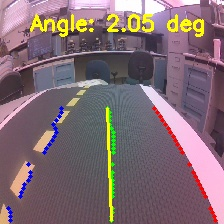

Slope error: 2.0454
Deviation from center: -0.008928571428571428


In [6]:
image = cv2.imread('Test_Lane_Images/image_1.jpg')
midpoint_img, middle, deviation = get_lane_midline_inner_edges_outlier_debug(image)
slope_img, slope_error = compute_slope_error(midpoint_img, middle, 1)

display(Image(data=bgr8_to_jpeg(slope_img)))
print(f"Slope error: {slope_error:.4f}" if slope_error is not None else "Not enough points for slope calculation.")
print("Deviation from center:", deviation)


In [ ]:
from jetbot import Robot, Camera, bgr8_to_jpeg
import cv2
import numpy as np
import ipywidgets as widgets
from scipy.signal import medfilt
from IPython.display import display, Image, clear_output
import time

robot = Robot()
# Initialize our camera
camera = Camera.instance()

# Save image data (modified to be numpy array)
image = np.array(camera.value)

jpeg_image = bgr8_to_jpeg(image)

# Display image within Jupyter Notebook
display(Image(data=jpeg_image))

In [ ]:
def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def iqr_filter(x_list):
    x = np.array(x_list)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [val for val in x if lower <= val <= upper]

def get_lane_midline_inner_edges_outlier_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === Sobel X edges ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === HSV yellow mask ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === Extract left (yellow ∩ sobel) and right (sobel only) points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === Overlay image ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if len(x_lefts) >= 3:
            x_lefts = iqr_filter(x_lefts)
        if len(x_rights) >= 3:
            x_rights = iqr_filter(x_rights)

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw edges
        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    # === Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === Save debug outputs ===
    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === Deviation computation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, mid_pts, deviation

def compute_slope_error(image, mid_pts, num_points=5):
    h, w = image.shape[:2]
    bottom_center = (w // 2, h - 1)
    if len(mid_pts) < num_points * 2:
        return None  # Not enough points

    top_pts = mid_pts[:num_points]

    x_top_avg = np.median([pt[0] for pt in top_pts])
    y_top_avg = np.median([pt[1] for pt in top_pts])

    if bottom_center[1] == y_top_avg:
        return None  # Prevent division by zero

    slope = (bottom_center[0] - x_top_avg) / (bottom_center[1] - y_top_avg)
    slope_error = 1/slope
    dx = bottom_center[0] - x_top_avg
    dy = bottom_center[1] - y_top_avg

    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    # Convert to angle w.r.t vertical (90° is ideal vertical line)
    slope_angle_from_vertical = 90 - angle_deg
    slope_error_angle = slope_angle_from_vertical

    out_img = image.copy()
    # Overlay line and text
    cv2.line(out_img, (int(x_top_avg), int(y_top_avg)), (int(bottom_center[0]), int(bottom_center[1])), (0, 255, 255), 2)
    cv2.putText(out_img, f"Angle: {slope_angle_from_vertical:.2f} deg", (30, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    return out_img, slope_error_angle

In [ ]:
from collections import deque

class SlopeFilter:
    def __init__(self, max_len=3, max_angle=40):
        self.buffer = deque(maxlen=max_len)
        self.max_angle = max_angle

    def update(self, new_val):
        if new_val is None:
            return self.get_median()

        if abs(new_val) <= self.max_angle:
            self.buffer.append(new_val)
        
        return self.get_median()

    def get_median(self):
        if not self.buffer:
            return 0.0  # default if empty
        return float(np.median(self.buffer))

# === PID controller class ===
class PIDController:
    def __init__(self, Kp=0.4, Kd=0.2):
        self.Kp = Kp
        self.Kd = Kd
        self.last_error = 0.0
        self.last_time = time.time()

    def compute(self, error):
        current_time = time.time()
        dt = current_time - self.last_time
        de = (error - self.last_error) / dt if dt > 0 else 0.0

        output = self.Kp * error + self.Kd * de

        self.last_error = error
        self.last_time = current_time
        return output

In [ ]:
import threading
# === UI Widgets ===
image = widgets.Image(format='jpeg', width=300, height=300)
slope_label = widgets.Label(value="Slope Error: ---")
control_label = widgets.Label(value="Control Output: ---")
kp_input = widgets.FloatText(value=0.0035, description='Kp')
kd_input = widgets.FloatText(value=0.001, description='Kd')

# Display everything
display(widgets.VBox([image, slope_label, control_label, kp_input, kd_input]))

# === Instances ===
filter = SlopeFilter(3, 40)
pid = PIDController(Kp=kp_input.value, Kd=kd_input.value)
# === Safe driving parameters ===
base_speed = 0.1  # forward throttle
max_turn = 0.05     # max allowed turn speed offset

# === Update Thread ===
def update_image():
    while True:
        try:
            img = camera.value
            mid_img, mid_pts, dev = get_lane_midline_inner_edges_outlier_debug(img, None)
            result = compute_slope_error(mid_img, mid_pts, 1)

            if result is not None:
                out_img, slope_error_angle = result
                image.value = bgr8_to_jpeg(out_img)

                filtered_slope = filter.update(slope_error_angle)
                slope_label.value = f"Slope Error: {filtered_slope:.2f}°"

                
            else:
                slope_label.value = "Slope Error: ---"
            # Update PID parameters from sliders
            pid.Kp = kp_input.value
            pid.Kd = kd_input.value

            control = pid.compute(filtered_slope)
            control = max(min(control, max_turn), -max_turn)
            control_label.value = f"Control Output: {control:.4f}"

            # Turning Mechanism
            left_speed = base_speed
            right_speed = base_speed + .035
            
            right_turn = right_speed - control   # turning right
            left_turn = left_speed + control  # turning left

            left_speed = max(left_speed, left_turn)
            right_speed = max(right_speed, right_turn)

            robot.set_motors(left_speed, right_speed)

        except Exception as e:
            slope_label.value = f"Error: {str(e)}"
            control_label.value = "Control Output: ---"

        time.sleep(0.05)

# === Start the Thread ===
threading.Thread(target=update_image, daemon=True).start()